# **PREPARATION PART**

Стивен из вселенной Стивена и международная космическая станция

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install multipledispatch
# !pip install sklearn.utils.multiclass.unique_labels
# !pip install sklearn.metrics.precision_recall_fscore_support

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Kinda important
import tensorflow as tf
from PIL import Image
import os
from urllib.request import urlopen
import io
import seaborn as sns
import random

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from multipledispatch import dispatch
import itertools
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

# Helper libraries
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import seaborn as sn
from copy import deepcopy

from urllib.error import HTTPError
import sys

# for augmentation part 
import albumentations as A

# for classification_report overriding
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import precision_recall_fscore_support
from tabulate import tabulate


Захотелось сделать красивое отображение отчёта
(P.S: на код не претендую,
[не мой](https://gist.github.com/prabz/019aa868ae8b5ec7b9dfa846cec34957),  но чуть изменён)

In [4]:
def classification_report(y_true, y_pred, labels=None, 
                          target_names=['Not Pumpyy pooo', 'Pumpy pooo'],
                          sample_weight=None, digits=4, tablfmt='pipe'):
    
    floatfmt = '.{:}f'.format(digits)
    if labels is None:
        labels = unique_labels(y_true, y_pred)
    else:
        labels = np.asarray(labels)

    if target_names is not None and len(labels) != len(target_names):
        print(
            "labels size, {0}, does not match size of target_names, {1}"
            .format(len(labels), len(target_names))
        )

    last_line_heading = 'avg / total'

    if target_names is None:
        target_names = [u'%s' % l for l in labels]

    headers = ["precision", "recall", "f1-score", "support"]

    p, r, f1, s = precision_recall_fscore_support(y_true, y_pred,
                                                  labels=labels,
                                                  average=None,
                                                  sample_weight=sample_weight)

    rows = zip(target_names, p, r, f1, s)
    tbl_rows = []
    for row in rows:
        tbl_rows.append(row)

    # compute averages
    last_row = (last_line_heading,
                np.average(p, weights=s),
                np.average(r, weights=s),
                np.average(f1, weights=s),
                np.sum(s))
    tbl_rows.append(last_row)
    return tabulate(tbl_rows, headers=headers,
                    tablefmt=tablfmt, floatfmt=floatfmt)

Нужно было при отладке. Оставлю, т.к не мешает и полезно

In [5]:
# TO SHOW IMAGE

@dispatch(list)
def magick(steeevaaa):
    global classes
    # print('fffffffffff')

    plt.figure(figsize=(8,8))
    plt.imshow(steeevaaa[0])
    plt.axis('off')

In [6]:
# TO SHOW AUG

@dispatch(np.ndarray)
def magick(steeevaaa):
    # print('fffffffffff')

    plt.figure(figsize=(8,8))
    plt.imshow(steeevaaa)
    plt.axis('off')

Просто позволяет вывести необходимую пару::

In [7]:
# TO SHOW IMAGES PAIR

@dispatch(list, list)
def magick(steeevaaa, issaaaa):
    global classes

    plt.figure(figsize=(8,8))
    
    for j, i in enumerate([steeevaaa, issaaaa]):
        plt.subplot(1, 2, j + 1)
        plt.title(classes[i[1]])
        plt.imshow(i[0])
        plt.axis('off')

In [8]:
# TO DOWNLOAD DATASET AND CHANGE SIZE
aug_ex = []

def download_set(data_path, class_name):

    global aug_ex

    global img_size
    only_img_list = []
    
    aug_ex = os.listdir(data_path)[200]

    for img in os.listdir(data_path):
        img_arr =  cv2.imread(os.path.join(data_path, str(img)))
        # color channel conversion and circumcision))
        img_arr = cv2.cvtColor(cv2.resize(img_arr, dsize=(img_size, img_size)), cv2.COLOR_BGR2RGB)
        only_img_list.append(img_arr)

    return only_img_list

/content/drive/MyDrive/steven/Стивен из вселенной Стивена и международная космическая станция/MKC
602 0
/content/drive/MyDrive/steven/Стивен из вселенной Стивена и международная космическая станция/Стивен из вселенной Стивена
520 1


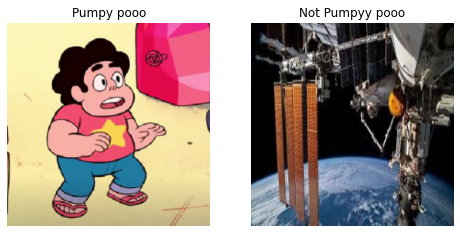

In [9]:
# FULL DATASET

full_ISS_dir = "/content/drive/MyDrive/steven/Стивен из вселенной Стивена и международная космическая станция/MKC"  # 602
full_Steven_dir = "/content/drive/MyDrive/steven/Стивен из вселенной Стивена и международная космическая станция/Стивен из вселенной Стивена"  # 520

directory = [full_ISS_dir, full_Steven_dir]

classes = ['Not Pumpyy pooo', 'Pumpy pooo']

full_img_list = []
full_base = []

img_size = 256

train_base = []
test_base = []
temp_arr = []

only_img_list_tr = []
only_img_list_tt = []

for d_set_path in directory:

    print(d_set_path)  # debag

    os.chdir(d_set_path)
    current_class = 0 if '/MKC' in d_set_path else 1
    full_img_list.extend(download_set(os.getcwd(), current_class))
    temp_arr = download_set(os.getcwd(), current_class)

    print(len(temp_arr), current_class)  # debag

    full_base.extend([[i, current_class] for i in temp_arr])

magick(full_base[800], full_base[4])

# **AUG PART**

In [10]:
def aug_img(aug_model, image):
    augmented = aug_model(image = image)        
    
    # image_aug = cv2.cvtColor(cv2.resize(augmented, dsize=(img_size, img_size)), cv2.COLOR_BGR2RGB)

    # image_aug = cv2.cvtColor(augmented['image'], cv2.COLOR_R)
    
    return augmented['image']

    # magick(image_aug)

In [11]:
random.seed(42)

color_aug = A.Compose([
    # A.RandomGamma(p=1),
    # A.RandomBrightnessContrast(p=1),
    # A.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4, p=1),
    # A.ChannelShuffle(p=1),
    A.FancyPCA(p=1),

], p=1)

coordination_aug = A.Compose([
    # A.Emboss(alpha=(0.2, 0.5), strength=(0.2, 0.7), p=1),
    # A.Equalize(mode="cv", by_channels=True, mask=None, mask_params=(), p=1),
    A.HorizontalFlip(p=1),
    A.Rotate(p=1),
])

quality_aug = A.Compose([
    # A.Blur(blur_limit=3, p=1),
    # A.CLAHE(clip_limit=7, tile_grid_size=(8, 8), p=1),
    # A.Downscale(scale_min=0.25, scale_max=0.25, interpolation=cv2.INTER_NEAREST, always_apply=True),
    # A.GaussNoise(var_limit=(50.0, 100.0), mean=0, per_channel=True, p=1),
    # A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.3, brightness_by_max=True, p=1), 
    A.RandomFog(fog_coef_lower=0.7, fog_coef_upper=1, alpha_coef=0.8, p=1),

])

affine_aug = A.Compose([
    A.Affine(scale=None, translate_percent=None, translate_px=None, rotate=None, 
             shear=[-30, 30], interpolation=1, mask_interpolation=0, cval=0, 
             cval_mask=0, mode=0, fit_output=False, keep_ratio=False, p=1),
])

stevaaaa_aug = A.Compose([
    A.ChannelShuffle(p=1),
    A.Affine(scale=None, translate_percent=None, translate_px=None, rotate=None, 
             shear=[-30, 30], interpolation=1, mask_interpolation=0, cval=0, 
             cval_mask=0, mode=0, fit_output=False, keep_ratio=False, p=1),
    
])

iisaaa_aug = A.Compose([
    A.HorizontalFlip(p=0.7),
    A.Rotate(p=1),
    A.GaussNoise(var_limit=(50.0, 100.0), mean=0, per_channel=True, p=0.7),
    A.Affine(scale=None, translate_percent=None, translate_px=None, rotate=None, 
             shear=[-30, 30], interpolation=1, mask_interpolation=0, cval=0, 
             cval_mask=0, mode=0, fit_output=False, keep_ratio=False, p=1),
    
])


In [12]:
def add_augmented_data(parents_dataset: np.ndarray):
    
    aug_parents_dataset = deepcopy(parents_dataset)

    for item in parents_dataset:

        if item[1] == 1:
            for i in range(2):
                aug_parents_dataset.append([aug_img(stevaaaa_aug, item[0]), item[1]])
            

        elif item[1] == 0:
            for i in range(2):
                aug_parents_dataset.append([aug_img(iisaaa_aug, item[0]), item[1]])

        # aug_parents_dataset.append([aug_img(aug_model, item[0]), item[1]])
        # t = [aug_img(aug_model, item[0]), item[1]]  # debag
    # print(aug_parents_dataset[1500])  # debag

    print(f'aug_parents_dataset size parametr: {len(aug_parents_dataset)}')  # debag

    return aug_parents_dataset

In [13]:
augmented_full_base = add_augmented_data(full_base)


aug_parents_dataset size parametr: 3366


In [14]:
print(augmented_full_base[1603][1])

0


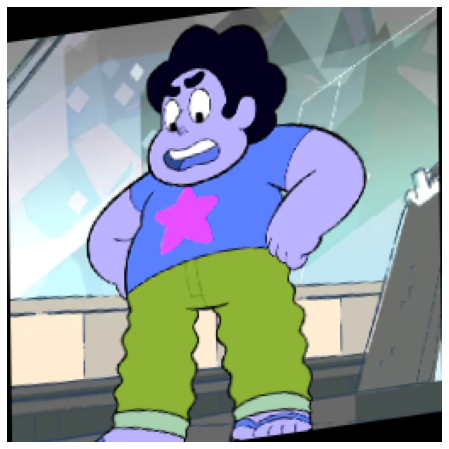

In [15]:
magick(augmented_full_base[3001][0])

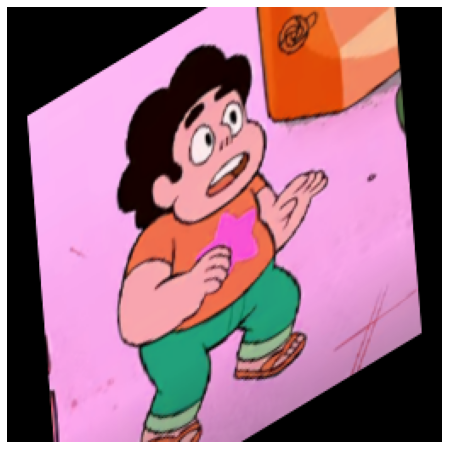

In [16]:
magick(aug_img(stevaaaa_aug, full_base[800][0]))

# **TENSOR PART**

In [17]:
# BUILDING A RIGHT ARRAY MODE

random.shuffle(augmented_full_base)

x_full = []
y_full = []

x_train = []
y_train = []

x_test = []
y_test = []

for img, cls in augmented_full_base:
    x_full.append(img)
    y_full.append(cls)

x_train, x_test, y_train, y_test = train_test_split(x_full, y_full, test_size=0.2, random_state=42, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, shuffle=True)

x_train = np.array(x_train)
x_test = np.array(x_test)

x_train = x_train.reshape(-1, img_size, img_size, 3)
x_train = x_train/255

x_test = x_test.reshape(-1, img_size, img_size, 3)
x_test = x_test/255

print(f'x_train shape is : {x_train.shape}')  # debag
print(f'x_test shape is : {x_test.shape}')  # debag

y_train = to_categorical(y_train, num_classes=2)
print(f'y_train shape is : {y_train.shape}')  # debag

y_test = to_categorical(y_test, num_classes = 2)

x_train shape is : (2153, 256, 256, 3)
x_test shape is : (674, 256, 256, 3)
y_train shape is : (2153, 2)


In [18]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, shuffle=True)

In [19]:
print(f'x_train is : {len(x_train)}')  # debag
print(f'x_val is : {len(x_val)}')  # debag
print(f'y_train is : {len(y_train)}')  # debag
print(f'y_val is : {len(y_val)}')  # debag

x_train is : 1722
x_val is : 431
y_train is : 1722
y_val is : 431


In [20]:
x_train1 = deepcopy(x_train)
x_val1 = deepcopy(x_val)
y_train1 = deepcopy(y_train)
y_val1 = deepcopy(y_val)

In [ ]:
x_train2 = deepcopy(x_train)
x_val2 = deepcopy(x_val)
y_train2 = deepcopy(y_train)
y_val2 = deepcopy(y_val)

# **Модель 1**

In [19]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(img_size, img_size,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

optimizer=Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 10
batch_size = 32
datagen = ImageDataGenerator(featurewise_center=False, 
                             samplewise_center=False, 
                             featurewise_std_normalization=False, 
                             samplewise_std_normalization=False, 
                             zca_whitening=False, 
                             zca_epsilon=0.000001, 
                             rotation_range=0.5, 
                             width_shift_range=0, 
                             height_shift_range=0, 
                             brightness_range=None, 
                             shear_range=0, 
                             zoom_range=0.5, 
                             channel_shift_range=0, 
                             fill_mode='nearest', 
                             cval=0, 
                             horizontal_flip=False, 
                             vertical_flip=False)

datagen.fit(x_train)
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs, steps_per_epoch=x_train.shape[0]//batch_size)

Epoch 1/10
53/53 [==============================] - 91s 2s/step - loss: 4.0851 - accuracy: 0.6367
Epoch 2/10
53/53 [==============================] - 88s 2s/step - loss: 0.3662 - accuracy: 0.8675
Epoch 3/10
53/53 [==============================] - 93s 2s/step - loss: 0.1967 - accuracy: 0.9296
Epoch 4/10
53/53 [==============================] - 96s 2s/step - loss: 0.1324 - accuracy: 0.9527
Epoch 5/10
53/53 [==============================] - 102s 2s/step - loss: 0.0910 - accuracy: 0.9692
Epoch 6/10
53/53 [==============================] - 93s 2s/step - loss: 0.0664 - accuracy: 0.9775
Epoch 7/10
53/53 [==============================] - 93s 2s/step - loss: 0.0350 - accuracy: 0.9876
Epoch 8/10
53/53 [==============================] - 93s 2s/step - loss: 0.0315 - accuracy: 0.9893
Epoch 9/10
53/53 [==============================] - 96s 2s/step - loss: 0.0239 - accuracy: 0.9917
Epoch 10/10
53/53 [==============================] - 93s 2s/step - loss: 0.0217 - accuracy: 0.9941


In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 16)        1216      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 4096)              0         
                                                                 
 dense_14 (Dense)            (None, 128)               524416    
                                                                 
 dense_15 (Dense)            (None, 2)                 258       
                                                                 
Total params: 525,890
Trainable params: 525,890
Non-trainable params: 0
________________________________________________

|                 |   precision |   recall |   f1-score |   support |
|:----------------|------------:|---------:|-----------:|----------:|
| Not Pumpyy pooo |      0.9873 |   0.9286 |     0.9571 |   84.0000 |
| Pumpy pooo      |      0.9077 |   0.9833 |     0.9440 |   60.0000 |
| avg / total     |      0.9542 |   0.9514 |     0.9516 |  144.0000 |


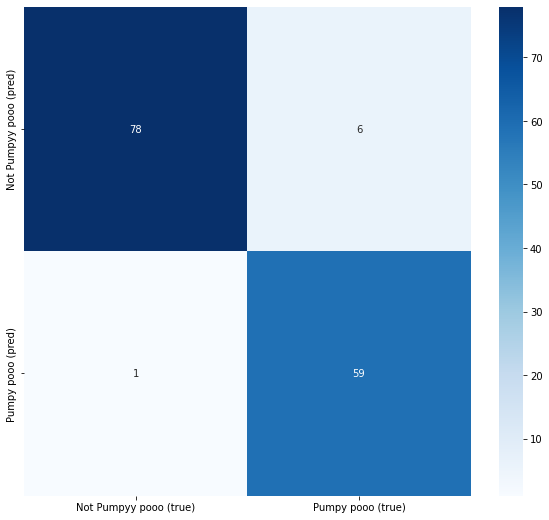

In [ ]:
# CONTROL VALIDATION: MODEL

from google.colab import data_table

y_pred = model.predict(x_val)
y_pred_cls = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)
conf_mat = confusion_matrix(y_true, y_pred_cls)
data_table.enable_dataframe_formatter()
print(classification_report(y_true, y_pred_cls))
f, ax = plt.subplots(figsize=(10, 9))
sns.heatmap(conf_mat, annot=True, fmt='.0f', cmap='Blues')
ax.set_xticklabels([item + ' (true)' for item in classes])
ax.set_yticklabels([item + ' (pred)' for item in classes])
plt.show()

|                 |   precision |   recall |   f1-score |   support |
|:----------------|------------:|---------:|-----------:|----------:|
| Not Pumpyy pooo |      1.0000 |   0.9147 |     0.9555 |  129.0000 |
| Pumpy pooo      |      0.8972 |   1.0000 |     0.9458 |   96.0000 |
| avg / total     |      0.9561 |   0.9511 |     0.9513 |  225.0000 |


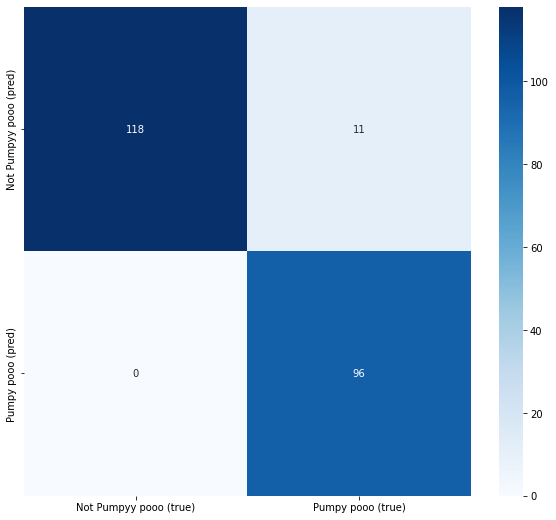

In [ ]:
# TEST: MODEL

y_predt = model.predict(x_test)
y_pred_clst = np.argmax(y_predt, axis=1)
y_truet = np.argmax(y_test, axis=1)
conf_matt = confusion_matrix(y_truet, y_pred_clst)
print(classification_report(y_truet, y_pred_clst))
f, ax = plt.subplots(figsize=(10, 9))
sns.heatmap(conf_matt, annot=True, fmt='.0f', cmap='Blues')
ax.set_xticklabels([item + ' (true)' for item in classes])
ax.set_yticklabels([item + ' (pred)' for item in classes])
plt.show()

# **Модель 2**

In [ ]:
model1 = Sequential()

model1.add(Conv2D(filters=16, kernel_size=(3,3), padding='Same', activation='relu', input_shape=(img_size, img_size,3)))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(2, activation='softmax'))

optimizer=Adam(learning_rate=0.001)
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 20
batch_size = 32
datagen = ImageDataGenerator(featurewise_center=False, 
                             samplewise_center=False, 
                             featurewise_std_normalization=False, 
                             samplewise_std_normalization=False, 
                             zca_whitening=False, 
                             zca_epsilon=0.000001, 
                             rotation_range=0.5, 
                             width_shift_range=0, 
                             height_shift_range=0, 
                             brightness_range=None, 
                             shear_range=0, 
                             zoom_range=0.5, 
                             channel_shift_range=0, 
                             fill_mode='nearest', 
                             cval=0, 
                             horizontal_flip=False, 
                             vertical_flip=False)

datagen.fit(x_train1)
history = model1.fit(datagen.flow(x_train1, y_train1, batch_size=batch_size), epochs=epochs, steps_per_epoch=x_train1.shape[0]//batch_size)

Epoch 1/20
17/17 [==============================] - 1s 32ms/step - loss: 0.6822 - accuracy: 0.6784
Epoch 2/20
17/17 [==============================] - 1s 32ms/step - loss: 0.2539 - accuracy: 0.9279
Epoch 3/20
17/17 [==============================] - 1s 32ms/step - loss: 0.1864 - accuracy: 0.9224
Epoch 4/20
17/17 [==============================] - 1s 34ms/step - loss: 0.1174 - accuracy: 0.9614
Epoch 5/20
17/17 [==============================] - 1s 33ms/step - loss: 0.0879 - accuracy: 0.9741
Epoch 6/20
17/17 [==============================] - 1s 32ms/step - loss: 0.0879 - accuracy: 0.9741
Epoch 7/20
17/17 [==============================] - 1s 36ms/step - loss: 0.0627 - accuracy: 0.9797
Epoch 8/20
17/17 [==============================] - 1s 33ms/step - loss: 0.0680 - accuracy: 0.9815
Epoch 9/20
17/17 [==============================] - 1s 31ms/step - loss: 0.0334 - accuracy: 0.9945
Epoch 10/20
17/17 [==============================] - 1s 32ms/step - loss: 0.0370 - accuracy: 0.9926
Epoch 11/

In [ ]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               524416    
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 525,122
Trainable params: 525,122
Non-trainable params: 0
________________________________________________

|                 |   precision |   recall |   f1-score |   support |
|:----------------|------------:|---------:|-----------:|----------:|
| Not Pumpyy pooo |      0.9882 |   1.0000 |     0.9941 |   84.0000 |
| Pumpy pooo      |      1.0000 |   0.9833 |     0.9916 |   60.0000 |
| avg / total     |      0.9931 |   0.9931 |     0.9930 |  144.0000 |


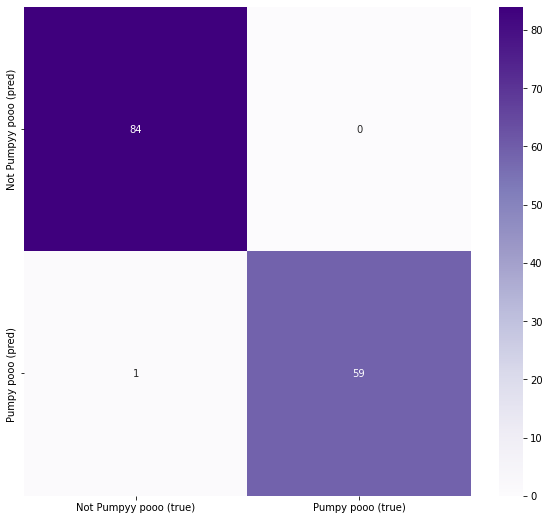

In [ ]:
# CONTROL VALIDATION: MODEL1

from google.colab import data_table

y_pred = model1.predict(x_val1)
y_pred_cls = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val1, axis=1)
conf_mat = confusion_matrix(y_true, y_pred_cls)
data_table.enable_dataframe_formatter()
print(classification_report(y_true, y_pred_cls))
f, ax = plt.subplots(figsize=(10, 9))
sns.heatmap(conf_mat, annot=True, fmt='.0f', cmap='Purples')
ax.set_xticklabels([item + ' (true)' for item in classes])
ax.set_yticklabels([item + ' (pred)' for item in classes])
plt.show()

|                 |   precision |   recall |   f1-score |   support |
|:----------------|------------:|---------:|-----------:|----------:|
| Not Pumpyy pooo |      1.0000 |   0.9767 |     0.9882 |  129.0000 |
| Pumpy pooo      |      0.9697 |   1.0000 |     0.9846 |   96.0000 |
| avg / total     |      0.9871 |   0.9867 |     0.9867 |  225.0000 |


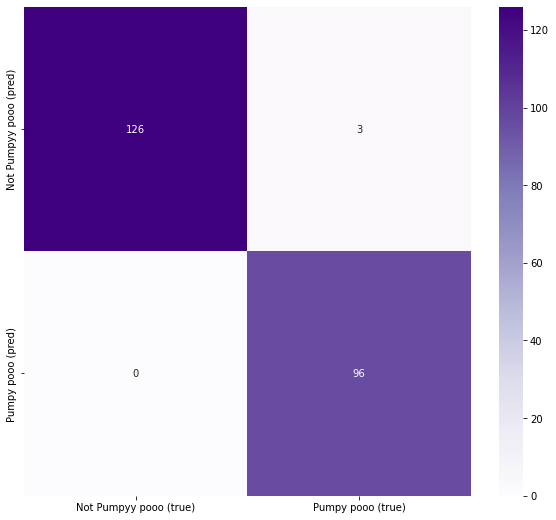

In [ ]:
# TEST: MODEL1

y_predt = model1.predict(x_test)
y_pred_clst = np.argmax(y_predt, axis=1)
y_truet = np.argmax(y_test, axis=1)
conf_matt = confusion_matrix(y_truet, y_pred_clst)
print(classification_report(y_truet, y_pred_clst))
f, ax = plt.subplots(figsize=(10, 9))
sns.heatmap(conf_matt, annot=True, fmt='.0f', cmap='Purples')
ax.set_xticklabels([item + ' (true)' for item in classes])
ax.set_yticklabels([item + ' (pred)' for item in classes])
plt.show()

# **Модель 3**

In [ ]:
model2 = Sequential()

model2.add(Conv2D(filters=16, kernel_size=(3,3), padding='Same', activation='relu', input_shape=(img_size, img_size,3)))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Flatten())
model2.add(Dense(32, activation='relu'))
model2.add(Dense(16))
model2.add(Dense(2, activation='softmax'))

optimizer=Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'], )
epochs = 20
batch_size = 32
datagen = ImageDataGenerator(featurewise_center=False, 
                             samplewise_center=False, 
                             featurewise_std_normalization=False, 
                             samplewise_std_normalization=False, 
                             zca_whitening=False, 
                             zca_epsilon=0.000001, 
                             rotation_range=0.5, 
                             width_shift_range=0, 
                             height_shift_range=0, 
                             brightness_range=None, 
                             shear_range=0, 
                             zoom_range=0.5, 
                             channel_shift_range=0, 
                             fill_mode='nearest', 
                             cval=0, 
                             horizontal_flip=False, 
                             vertical_flip=False)

datagen.fit(x_train2)
history = model2.fit(datagen.flow(x_train2, y_train2, batch_size=batch_size), epochs=epochs, steps_per_epoch=x_train2.shape[0]//batch_size)

Epoch 1/20
17/17 [==============================] - 1s 28ms/step - loss: 0.6810 - accuracy: 0.6026
Epoch 2/20
17/17 [==============================] - 1s 29ms/step - loss: 0.3742 - accuracy: 0.8632
Epoch 3/20
17/17 [==============================] - 1s 30ms/step - loss: 0.1936 - accuracy: 0.9501
Epoch 4/20
17/17 [==============================] - 1s 29ms/step - loss: 0.1512 - accuracy: 0.9522
Epoch 5/20
17/17 [==============================] - 1s 30ms/step - loss: 0.0850 - accuracy: 0.9778
Epoch 6/20
17/17 [==============================] - 1s 31ms/step - loss: 0.0727 - accuracy: 0.9798
Epoch 7/20
17/17 [==============================] - 1s 29ms/step - loss: 0.0566 - accuracy: 0.9834
Epoch 8/20
17/17 [==============================] - 1s 30ms/step - loss: 0.0470 - accuracy: 0.9889
Epoch 9/20
17/17 [==============================] - 1s 31ms/step - loss: 0.0336 - accuracy: 0.9908
Epoch 10/20
17/17 [==============================] - 1s 30ms/step - loss: 0.0393 - accuracy: 0.9908
Epoch 11/

In [ ]:
model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 4096)              0         
                                                                 
 dense_18 (Dense)            (None, 32)                131104    
                                                                 
 dense_19 (Dense)            (None, 16)                528       
                                                                 
 dense_20 (Dense)            (None, 2)                 34        
                                                      

|                 |   precision |   recall |   f1-score |   support |
|:----------------|------------:|---------:|-----------:|----------:|
| Not Pumpyy pooo |      1.0000 |   0.9600 |     0.9796 |   75.0000 |
| Pumpy pooo      |      0.9583 |   1.0000 |     0.9787 |   69.0000 |
| avg / total     |      0.9800 |   0.9792 |     0.9792 |  144.0000 |


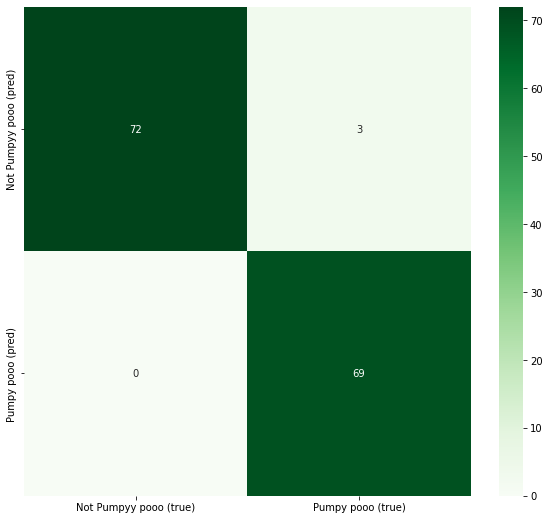

In [ ]:
# CONTROL VALIDATION: MODEL2

from google.colab import data_table

y_pred2 = model2.predict(x_val2)
y_pred_cls2 = np.argmax(y_pred, axis=1)
y_true2 = np.argmax(y_val2, axis=1)
conf_mat2 = confusion_matrix(y_true2, y_pred_cls2)
data_table.enable_dataframe_formatter()
print(classification_report(y_true2, y_pred_cls2))
f, ax = plt.subplots(figsize=(10, 9))
sns.heatmap(conf_mat2, annot=True, fmt='.0f', cmap='Greens')
ax.set_xticklabels([item + ' (true)' for item in classes])
ax.set_yticklabels([item + ' (pred)' for item in classes])
plt.show()

|                 |   precision |   recall |   f1-score |   support |
|:----------------|------------:|---------:|-----------:|----------:|
| Not Pumpyy pooo |      0.9916 |   1.0000 |     0.9958 |  118.0000 |
| Pumpy pooo      |      1.0000 |   0.9907 |     0.9953 |  107.0000 |
| avg / total     |      0.9956 |   0.9956 |     0.9956 |  225.0000 |


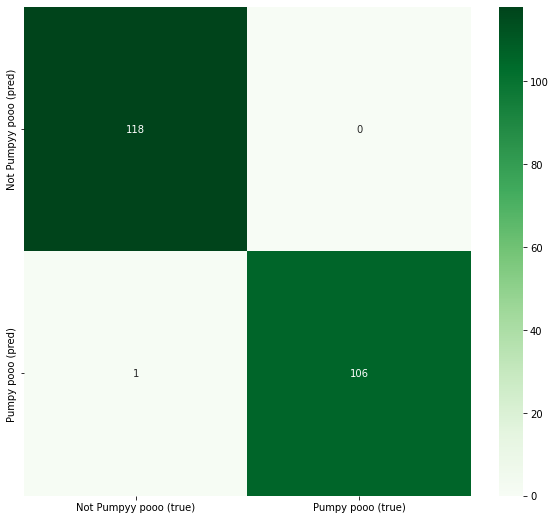

In [ ]:
# TEST: MODEL2

y_predt = model2.predict(x_test)
y_pred_clst = np.argmax(y_predt, axis=1)
y_truet = np.argmax(y_test, axis=1)
conf_matt = confusion_matrix(y_truet, y_pred_clst)
print(classification_report(y_truet, y_pred_clst))
f, ax = plt.subplots(figsize=(10, 9))
sns.heatmap(conf_matt, annot=True, fmt='.0f', cmap='Greens')
ax.set_xticklabels([item + ' (true)' for item in classes])
ax.set_yticklabels([item + ' (pred)' for item in classes])
plt.show()

In [ ]:
# os.remove('/content/drive/MyDrive/steven/Стивен из вселенной Стивена и международная космическая станция/Стивен из вселенной Стивена/Screenshot_520.png')

# **Единичное предсказание по ссылке**

*   Было упомянуто, что если что-то будет не так, то будете выборочную фотку по ссылке загружать в predict. Не знаем требовалось ли это делать, но теперь можно вставить через get_check ссылку на картинку. Примеры на которых работало в комментариях. Не работало только с картинками, которые по видимому были заблокированы для такой операции (по нашему мнению, может ошибаемся).
*   Убрали отчёт, потому что слишком круто для одной картинки. 

In [ ]:
def get_check(link, class_name):
    global img_size
    global true
    
    true = class_name
    fd = urlopen(link)

    image_file = io.BytesIO(fd.read())
    img = Image.open(image_file)
    img_arr = np.array(img)
    img_arr[20,30]
    plt.axis('off')


    img_arr = cv2.resize(img_arr, dsize=(img_size, img_size))

    plt.imshow(img_arr)  # debag
    
    # plt.savefig("/content/drive/MyDrive/steven/Стивен из вселенной Стивена и международная космическая станция/Стивен из вселенной Стивена/Screenshot_520.png")


    img_arr = img_arr.reshape(-1, img_size, img_size, 3)
    img_arr = img_arr/255

    return img_arr

**Пояснение к использованию:**


---

Вставлять ссылку вместо уже вставленной как пример ссылки. 

Вторым параметром служит класс изображения на данной картинке. Он будет использоваться как верное значение, с которым будет сравниваться наше предсказание. Названия класса примлемы только в виде 'Steven' и 'ISS'. 


Predict: its Pumpy pooo
Probability is: 99.96700286865234%


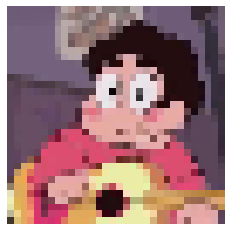

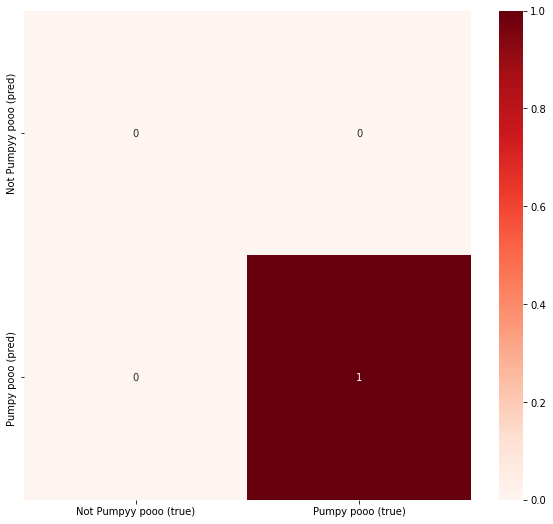

In [ ]:
# URL IMAGE WORK ON MODEL

# Pumpy pooo
# https://c-cl.cdn.smule.com/rs-s87/arr/f8/65/e4b2a575-fbf4-4611-8f10-643c4b94bac6.jpg
# https://media.myshows.me/shows/1920/c/19/c19d86c712121a60f9ad75979d5860f7.jpg
# https://slovnet.ru/wp-content/uploads/2018/08/1-29.jpg  # dark bg

# Not Pumpyy pooo
# https://cdni.russiatoday.com/rbthmedia/images/2020.12/article/5feb853a85600a4a470fb151.jpg 

true = str

y_pred = model.predict(get_check("https://c-cl.cdn.smule.com/rs-s87/arr/f8/65/e4b2a575-fbf4-4611-8f10-643c4b94bac6.jpg ", 'Steven'))
y_pred_cls = np.argmax(y_pred, axis=1)

if true == 'Steven':
    y_true = [1] 
elif true == 'ISS':
    y_true = [0]
if y_true == y_pred_cls:
    print(f'Predict: its {classes[y_pred_cls[0]]}')
    print(f'Probability is: {round(np.amax([item * 100 for item in y_pred]), 3)}%')
else:
    print(f'Error. Its not {true}')
    print("y_pred = ", y_pred * 100)

conf_mat = confusion_matrix(y_true, y_pred_cls, labels=[0, 1])
f, ax = plt.subplots(figsize=(10, 9))
sns.heatmap(conf_mat, annot=True, fmt='.0f', cmap='Reds')
ax.set_xticklabels([item + ' (true)' for item in classes])
ax.set_yticklabels([item + ' (pred)' for item in classes])
plt.show()